# Learning programming representations

We are going to represent programs as token vectors and learn their representations.

 We are going to learn a representation of these programs. We are going to create a prediction problem and try to predict whether the program submitted with be considered as correct, i.e. the program pass the testcases specified by the lecturer. Creating a prediction problem to learn representations of the data is a useful approach. There is no easy way to represent these programs so we are going to learn these representations. 
 

* https://code.google.com/archive/p/word2vec/

* https://medium.com/@sabber/classifying-yelp-review-comments-using-cnn-lstm-and-pre-trained-glove-word-embeddings-part-3-53fcea9a17fa

* https://www.cse.iitb.ac.in/~pb/papers/bionlp-acl17-medical-coding.pdf

* https://github.com/sloomba/protein2vec

* https://github.com/samiroid/usr2vec

* https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py

* http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/

* Topic Modelling for Humans: https://radimrehurek.com/gensim/

* https://spacy.io/models/

* https://www.shanelynn.ie/get-busy-with-word-embeddings-introduction/

* Code2Vec https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8031179&tag=1, https://arxiv.org/pdf/1803.09473.pdf, https://code2vec.org/

* From People2Vec to Emotional AI: http://people2vec.org/

* Using Word2vec for Music Recommendations: https://towardsdatascience.com/using-word2vec-for-music-recommendations-bb9649ac2484

* Source code identifier embeddings: https://blog.sourced.tech/post/id2vec/

* Recommending Recommendation Systems: https://gab41.lab41.org/recommending-recommendation-systems-cc39ace3f5c1, https://github.com/Lab41/Misc/blob/master/blog/python2vec/Python2Vec%20Example.ipynb

* Python2Vec: Word Embeddings for Source Code: https://gab41.lab41.org/python2vec-word-embeddings-for-source-code-3d14d030fe8f

* Anything2Vec: https://gab41.lab41.org/anything2vec-e99ec0dc186

* AutoKeras: https://towardsdatascience.com/autokeras-the-killer-of-googles-automl-9e84c552a319, https://autokeras.com/

* Learning Program Embeddings to Propagate Feedback on Student Code: https://web.stanford.edu/~cpiech/bio/papers/programEncoding.pdf, https://github.com/chrispiech/refactoredEncoder

* Research at Code.org: https://code.org/research

* Cheatsheet: https://startupsventurecapital.com/essential-cheat-sheets-for-machine-learning-and-deep-learning-researchers-efb6a8ebd2e5

* DCU Deep Learning Summer School: https://telecombcn-dl.github.io/2018-dlcv/, https://www.slideshare.net/xavigiro/d1l2-the-neural-network-zoo-upc-2018-deep-learning-for-computer-vision

* Embeddings: https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture

In [80]:
import os
import json
import tensorflow as tf
import keras
import sys
import numpy as np
import pandas as pd
import itertools
import collections
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

## Programming data

Student develop programs locally for the laboratory sheets of computer programming courses at our university. These programs are submitted by them to an automatic grading platform that runs some test cases specified by the lecturer on each program. A JSON output for those testcases and whether the program passed them or not along with the actual code is stored.

In [2]:
pg = pd.read_json('data/programming_data.json')

In [3]:
'{:,}'.format(len(pg))

'641,153'

In [4]:
pg.head(2)

,academic_year,correct,date,error,extension,failed,ip,module,passed,task,timeout,upload,user
0,"[2016, 2017]",True,2016-09-19 14:11:41,,py,0,,ca277,2,add.py,3,#!/usr/bin/env python\n\na = int(raw_input())\...,95a41753-9092-4aa1-9f54-d4793345e8cf
1,"[2016, 2017]",True,2016-09-19 14:17:33,,py,0,,ca277,2,concat-lines.py,3,#!/usr/bin/env python\n\na = str(raw_input())\...,95a41753-9092-4aa1-9f54-d4793345e8cf


## Grades data

In these programming courses, students are assesed by taking two or three laboratory exams throughout the semester. 

In [13]:
grades_data = json.load(open('data/grades_data.json'))

In [14]:
'{:,}'.format(len(grades_data))

'2,042'

## Programs as word vectors

We are going to treat the programs students write and submit to our platform as word vectors. We are going to learn a representation of these programs. We are going to create a prediction problem and try to predict whether the program submitted with be considered as correct, i.e. the program pass the testcases specified by the lecturer. Creating a prediction problem to learn representations of the data is a useful approach. There is no easy way to represent these programs so we are going to learn these representations. 

In [5]:
import re
def remove_comments(text):
    return re.sub(re.compile('#.*?\n'), '', text)

In [6]:
program = '#!/usr/bin/env python\n\na = int(raw_input())\nb = int(raw_input())\n\nprint a + b\n\n\n'
remove_comments(program)

'\na = int(raw_input())\nb = int(raw_input())\n\nprint a + b\n\n\n'

In [7]:
program = '''
#!/usr/bin/env python
# read from input
a = int(raw_input()) # first
b = int(raw_input()) # second
print a + b
'''
remove_comments(program)

'\na = int(raw_input()) b = int(raw_input()) print a + b\n'

In [8]:
from keras.preprocessing.text import text_to_word_sequence
text_to_word_sequence?

In [9]:
text_to_word_sequence(remove_comments(program), lower=True, split=' ')

['a', 'int', 'raw', 'input', 'b', 'int', 'raw', 'input', 'print', 'a', 'b']

By default in text_to_word_sequence the filters are:

> filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

See the function signature

In [10]:
text_to_word_sequence(remove_comments(program), 
                      filters='\t\n',
                      lower=True, 
                      split=' ')

['a',
 '=',
 'int(raw_input())',
 'b',
 '=',
 'int(raw_input())',
 'print',
 'a',
 '+',
 'b']

It still does not represent a programming submission in a very comparable way to other submissions. We are going to run the following notebook where we tokenize the program given a vocabulary:

In [11]:
# http://nbviewer.jupyter.org/gist/minrk/5491090/analysis.ipynb

#import io
#from IPython.nbformat import current

#def execute_notebook(nbfile):
#    with io.open(nbfile) as f:
#        nb = current.read(f, 'json')
#    ip = get_ipython()
#    for cell in nb.worksheets[0].cells:
#        if cell.cell_type != 'code':
#            continue
#        ip.run_cell(cell.input)

In [12]:
# execute_notebook("Tokenize Python programs.ipynb")

In [13]:
# get_tokens(program)

In [14]:
from tokenize import generate_tokens
from StringIO import StringIO

In [15]:
tokens = [t[0] for t in list(generate_tokens(StringIO(program).readline))]

In [16]:
print tokens

[54, 53, 54, 53, 54, 1, 51, 1, 51, 1, 51, 51, 51, 53, 4, 1, 51, 1, 51, 1, 51, 51, 51, 53, 4, 1, 1, 51, 1, 4, 0]


In [17]:
[t[1] for t in list(generate_tokens(StringIO(program).readline))]

['\n',
 '#!/usr/bin/env python',
 '\n',
 '# read from input',
 '\n',
 'a',
 '=',
 'int',
 '(',
 'raw_input',
 '(',
 ')',
 ')',
 '# first',
 '\n',
 'b',
 '=',
 'int',
 '(',
 'raw_input',
 '(',
 ')',
 ')',
 '# second',
 '\n',
 'print',
 'a',
 '+',
 'b',
 '\n',
 '']

In [18]:
def get_tokens(code, pos=0):
    '''
    Get tokens
    Arguments: 
    - code
    - pos: 0: token IDs, 1: tokens
    '''
    try:
        return [t[pos] for t in list(generate_tokens(StringIO(remove_comments(code)).readline))]
    except:
        return None

In [19]:
get_tokens(program, pos=1)

['\n',
 'a',
 '=',
 'int',
 '(',
 'raw_input',
 '(',
 ')',
 ')',
 'b',
 '=',
 'int',
 '(',
 'raw_input',
 '(',
 ')',
 ')',
 'print',
 'a',
 '+',
 'b',
 '\n',
 '']

In [20]:
get_tokens(program, pos=0)

[54,
 1,
 51,
 1,
 51,
 1,
 51,
 51,
 51,
 1,
 51,
 1,
 51,
 1,
 51,
 51,
 51,
 1,
 1,
 51,
 1,
 4,
 0]

That looks better! We are only applying those two filters in order to have a more accurate representation of the programs. 

## Word embeddings example

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

In [51]:
# define documents
docs = ['Well done!',
		'Good work',
		'Great effort',
		'nice work',
		'Excellent!',
		'Weak',
		'Poor effort!',
		'not good',
		'poor work',
		'Could have done better.']
# define class labels
labels = array([1,1,1,1,1,0,0,0,0,0])

In [54]:
# integer encode the documents
vocab_size = 50
encoded_docs = [one_hot(d, vocab_size) for d in docs]
print(encoded_docs)

[[25, 48], [18, 22], [39, 3], [17, 22], [28], [37], [3, 3], [40, 18], [3, 22], [40, 19, 48, 4]]


In [55]:
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[25 48  0  0]
 [18 22  0  0]
 [39  3  0  0]
 [17 22  0  0]
 [28  0  0  0]
 [37  0  0  0]
 [ 3  3  0  0]
 [40 18  0  0]
 [ 3 22  0  0]
 [40 19 48  4]]


In [56]:
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 8)              400       
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________
None


In [57]:
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f, Loss: %f' % (accuracy * 100, loss * 100))

Accuracy: 89.999998


## Program2vec for a particular task

In [24]:
codes = pg[(pg['task'] == 'all-suffixes.py') & 
           (pg['module'] == 'ca116')]

In [25]:
'{:,}'.format(codes.shape[0])

'588'

In [26]:
codes.head(1)

,academic_year,correct,date,error,extension,failed,ip,module,passed,task,timeout,upload,user
3338,"[2015, 2016]",True,2016-10-11 14:37:34,,py,0,,ca116,2,all-suffixes.py,3,s=raw_input()\ni=0\n\nwhile i<len(s):\n print...,28dec824-d35a-4d11-8ca4-35cf55325e25


In [27]:
len(codes['user'].unique())

249

In [28]:
codes['correct'].value_counts(dropna=False)

True     461
False    127
Name: correct, dtype: int64

In [22]:
def get_docs_and_labels(dataframe):
    docs = []
    labels = []
    for index in dataframe.index:
        # Program
        program = get_tokens(dataframe.get_value(index, 'upload'), pos=1)
        if program is not None:
            docs.append(program)
            # Label
            label = int(dataframe.get_value(index, 'correct'))
            labels.append(label)
    return docs, labels

In [29]:
docs, labels = get_docs_and_labels(codes)

In [30]:
len(docs), len(labels)

(582, 582)

In [31]:
collections.Counter(labels)

Counter({0: 121, 1: 461})

In [32]:
docs[0]

[u's',
 u'=',
 u'raw_input',
 u'(',
 u')',
 u'\n',
 u'i',
 u'=',
 u'0',
 u'\n',
 u'\n',
 u'while',
 u'i',
 u'<',
 u'len',
 u'(',
 u's',
 u')',
 u':',
 u'\n',
 u'  ',
 u'print',
 u's',
 u'[',
 u'i',
 u':',
 u'len',
 u'(',
 u's',
 u')',
 u']',
 u'\n',
 u'i',
 u'=',
 u'i',
 u'+',
 u'1',
 u'\n',
 '',
 '']

In [33]:
words  = set(list(itertools.chain(*docs)))

In [35]:
len(words)

74

In [36]:
words = list(words)

In [61]:
vocab_size = len(words)
vocab_size

74

In [37]:
word_to_id = {v: k for k, v in enumerate(words)}

In [77]:
word_to_id['import']

36

In [41]:
id_to_word = { v: k for k, v in word_to_id.iteritems() }

In [78]:
id_to_word[15]

u'if'

In [43]:
# encoded_docs = [one_hot(str(d), vocab_size) for d in docs]

In [44]:
encoded_docs = [[word_to_id[w] for w in doc] for doc in docs]

In [45]:
len(encoded_docs[0])

40

In [46]:
encoded_docs[0][1:3]

[38, 63]

In [49]:
# pad documents to a max length of 40 words
max_length = 40
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[28 38 63 ...,  5  0  0]
 [28 38 63 ...,  0  0  0]
 [28 38 63 ...,  0  0  0]
 ..., 
 [28 38 63 ...,  0  0  0]
 [ 5 28 38 ...,  0  0  0]
 [ 5 28 38 ...,  0  0  0]]


In [81]:
# top words
def get_top_words(encoded_docs, N=10):
    
    # count occurrences
    count_w = {}
    for d in encoded_docs:
        for w in d:
            count_w.setdefault(w, 0)
            count_w[w] += 1

    # top words
    top_words = []
    for key, value in sorted(count_w.iteritems(), key=lambda (k,v): (v,k), reverse=True)[:N]:
        print "Word: %s, occurrences: %s" % (key, value)
        top_words.append(key)
    
    return top_words

In [ ]:
top_words = get_top_words(encoded_docs)

In [58]:
top_words

[5, 62, 28, 38, 24, 23, 0, 37, 50, 29]

In [62]:
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 8)             592       
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 321       
Total params: 913
Trainable params: 913
Non-trainable params: 0
_________________________________________________________________
None


In [63]:
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f, Loss: %f' % (accuracy * 100, loss * 100))

Accuracy: 94.158076


In [65]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def get_pca(embeddings):

    # PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(embeddings)
    print 'PCA explained variance ratio:', pca.explained_variance_ratio_, 'Total:', sum(pca.explained_variance_ratio_)
    return principal_components
    
def get_tsne(embeddings):
    
    # tSNE
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    low_dim_embs = tsne.fit_transform(embeddings)
    return low_dim_embs

In [66]:
# Colors
# https://matplotlib.org/examples/color/named_colors.html
colors = ['r', 'b', 'b', 'g', 'c', 'm', 'y', 'orange', 
          'chocolate', 'salmon', 'k', 'violet', 'lightblue', 'lightgreen']
assert len(colors) >= len(set(labels)), "More colors than labels"

In [67]:
# Assign colors to parties for visualizations
label_to_color = {}
# label_to_color[''] = 'w' # white for padding
i = 0
for p in set(labels):
    label_to_color[p] = colors[i]
    i += 1
label_to_color

{0: 'r', 1: 'b'}

In [68]:
def get_embeddings(model):

    # Embedding Layer
    embedding_layer = model.layers[0]
    embeddings = embedding_layer.get_weights()[0]
    print 'Embedding Layer shape:', embeddings.shape
    
    return embeddings

In [69]:
embeddings = get_embeddings(model)

Embedding Layer shape: (74, 8)


In [70]:
embeddings[0]

array([-0.1765551 ,  0.00865538, -0.07850773,  0.08228953, -0.0046515 ,
        0.01147778,  0.12283555,  0.15915871], dtype=float32)

In [71]:
id_to_word[0], id_to_word[10]

('', u'in')

In [72]:
pg_pca = get_pca(embeddings)

PCA explained variance ratio: [ 0.34933829  0.21837717] Total: 0.567715466022


In [73]:
pg_pca[0]

array([-0.17395057,  0.20991313], dtype=float32)

In [82]:
def plot_dimensionality_reduction(low_dim_embs, d, top_words=[], figsize=(18, 18)):
    assert low_dim_embs.shape[0] >= len(id_to_word), "More labels than embeddings"
    plt.figure(figsize=figsize, dpi=100)
    i = 0
    while i < len(low_dim_embs):
        
        if len(top_words) == 0 or i in top_words:

            # Plot
            x, y = low_dim_embs[i, :]
            word = id_to_word[i]

            plt.scatter(x, y, color='b')
            plt.annotate(word,
                        xy=(x, y),
                        xytext=(5, 2),
                        textcoords='offset points',
                        ha='right',
                        va='bottom',
                        fontsize=14)
        
        i += 1

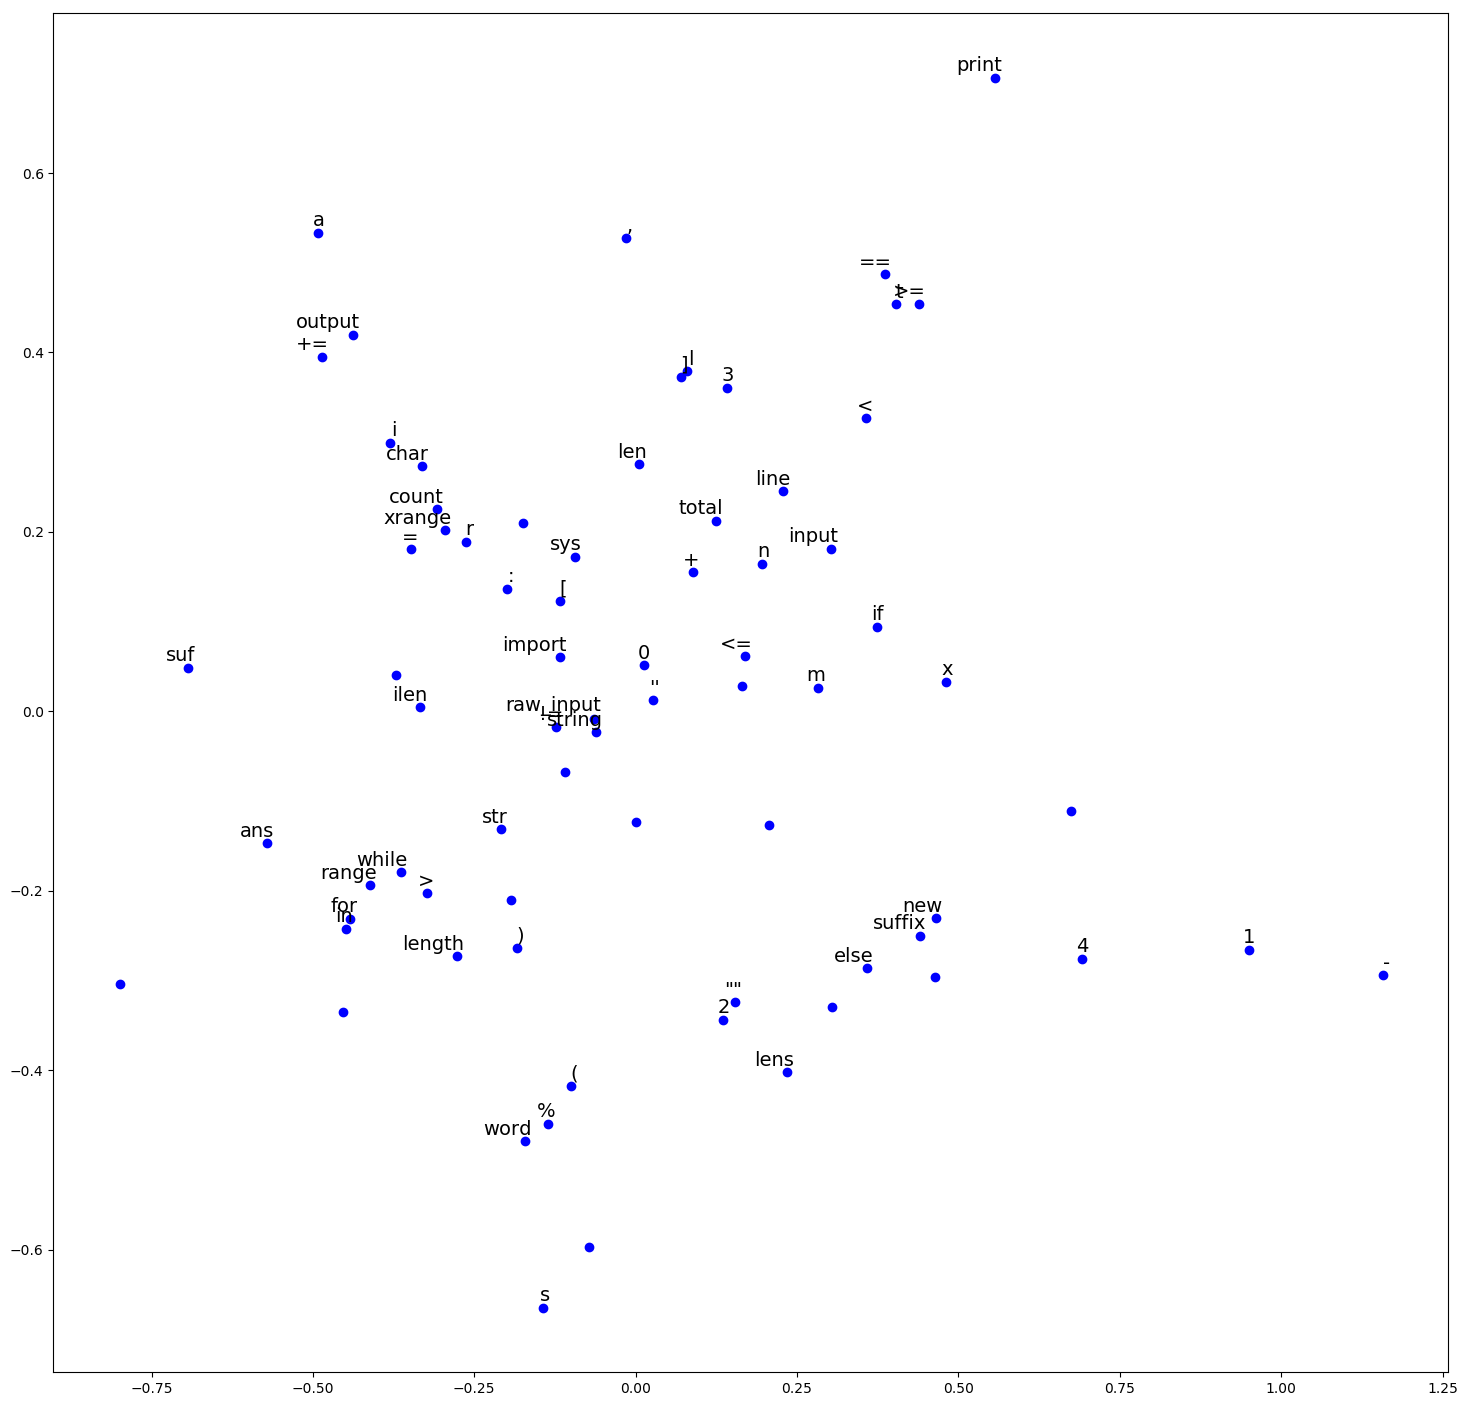

In [75]:
plot_dimensionality_reduction(pg_pca, id_to_word)

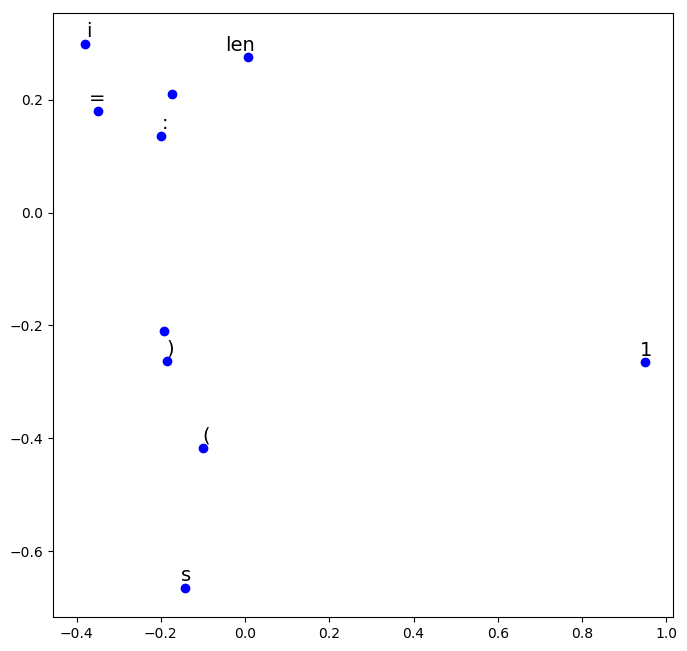

In [84]:
plot_dimensionality_reduction(pg_pca, id_to_word, top_words=top_words, figsize=(8, 8))

## Program2vec for all student python programs available to us

Grab all programs with PY extension, token and train a network, plot the embeddings, see the result, see if with those vectors you can classify students between good and bad based on the use of the vectors???

In [85]:
pg['module'].unique()

array([u'ca277', u'ca116', u'ca117', u'ca278', u'ca000', u'ca114',
       u'ca177', u'ca247', u'ca320'], dtype=object)

In [86]:
pyprog = pg[(pg['extension'] == 'py') & 
            (pg['module'].isin(['ca116', 'ca117', 'ca177', 'ca277', 'ca278']))]

In [87]:
pyprog.head(2)

,academic_year,correct,date,error,extension,failed,ip,module,passed,task,timeout,upload,user
0,"[2016, 2017]",True,2016-09-19 14:11:41,,py,0,,ca277,2,add.py,3,#!/usr/bin/env python\n\na = int(raw_input())\...,95a41753-9092-4aa1-9f54-d4793345e8cf
1,"[2016, 2017]",True,2016-09-19 14:17:33,,py,0,,ca277,2,concat-lines.py,3,#!/usr/bin/env python\n\na = str(raw_input())\...,95a41753-9092-4aa1-9f54-d4793345e8cf


In [88]:
'{:,}'.format(pyprog.shape[0])

'527,241'

In [89]:
len(pyprog['user'].unique())

532

In [90]:
docs, labels = get_docs_and_labels(pyprog)

In [91]:
len(docs)

507141

In [92]:
words  = set(list(itertools.chain(*docs)))

In [93]:
'Number of words: {:,}'.format(len(words))

'Number of words: 41,989'

In [94]:
vocab_size = len(words)

In [95]:
words = list(words)

In [96]:
word_to_id = {v: k for k, v in enumerate(words)}

In [98]:
id_to_word = { v: k for k, v in word_to_id.iteritems() }

In [100]:
encoded_docs = [[word_to_id[w] for w in doc] for doc in docs]

In [101]:
# pad documents to a max length of 100 words
max_length = 100
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[27567  3512 20634 ...,     0     0     0]
 [27567  3512 20634 ...,     0     0     0]
 [27567 27873   273 ...,     0     0     0]
 ..., 
 [33518 40652 36950 ...,     0     0     0]
 [33518 40652 36950 ...,     0     0     0]
 [33518 40652 36950 ...,     0     0     0]]


In [102]:
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          4198900   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 10001     
Total params: 4,208,901
Trainable params: 4,208,901
Non-trainable params: 0
_________________________________________________________________
None


In [103]:
# fit the model
model.fit(padded_docs, labels, epochs=2)

Epoch 1/2
507141/507141 [==============================] - 1099s 2ms/step - loss: 0.5462 - acc: 0.7152
Epoch 2/2
507141/507141 [==============================] - 1369s 3ms/step - loss: 0.4508 - acc: 0.7804


In [104]:
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels)

507141/507141 [==============================] - 64s 126us/step


In [105]:
print('Accuracy: %f' % (accuracy * 100))
print('Loss: %f' % (loss * 100))

Accuracy: 80.633591
Loss: 40.231797


In [106]:
embeddings = get_embeddings(model)

Embedding Layer shape: (41989, 100)


In [109]:
embeddings[0]

array([ 0.03030861, -0.03934757,  0.00102791, -0.02574248, -0.01695869,
       -0.02318399,  0.00299696,  0.01092644,  0.01323475, -0.01920119,
       -0.01421608, -0.00867848,  0.01606243, -0.00953969,  0.03561374,
        0.00400496,  0.00915089,  0.00226779,  0.00835475,  0.03740052,
       -0.00865663, -0.00624962,  0.00799046, -0.00578366, -0.00970622,
        0.035974  ,  0.00217296,  0.01829106, -0.02981361, -0.01008521,
        0.0072174 ,  0.00177373, -0.009357  ,  0.00438108, -0.00927577,
        0.00037745,  0.01594697, -0.04548944, -0.02580115,  0.0177561 ,
        0.00054393,  0.03890758,  0.02627285,  0.01265732,  0.00203123,
       -0.01502195, -0.02704064, -0.03959084,  0.02803383,  0.01692226,
       -0.0325416 , -0.02439744,  0.03541235,  0.00170114, -0.02530819,
        0.02636713, -0.00061573,  0.03184976,  0.04700562, -0.00889805,
        0.00208392,  0.0156718 ,  0.01163814,  0.01014984, -0.02018589,
       -0.00871896,  0.01812937,  0.00431373,  0.00267787,  0.00

In [112]:
import pickle

with open('data/my_embeddings.pickle', 'w') as f:
    pickle.dump(embeddings, f)

In [113]:
top_words = get_top_words(encoded_docs, N=100)

Word: 27567, occurrences: 7491776
Word: 7537, occurrences: 3847096
Word: 25992, occurrences: 3847074
Word: 20634, occurrences: 2739931
Word: 0, occurrences: 2492065
Word: 33518, occurrences: 2403906
Word: 425, occurrences: 2147621
Word: 15415, occurrences: 1404646
Word: 36950, occurrences: 1382183
Word: 19077, occurrences: 1368432
Word: 24656, occurrences: 1368386
Word: 7100, occurrences: 946120
Word: 1606, occurrences: 862655
Word: 29749, occurrences: 815433
Word: 5844, occurrences: 765417
Word: 27873, occurrences: 760057
Word: 13012, occurrences: 679835
Word: 8186, occurrences: 569173
Word: 16107, occurrences: 566096
Word: 3512, occurrences: 559343
Word: 17105, occurrences: 484269
Word: 1071, occurrences: 478655
Word: 232, occurrences: 453525
Word: 16103, occurrences: 449371
Word: 12362, occurrences: 432276
Word: 12229, occurrences: 422820
Word: 33932, occurrences: 394309
Word: 35934, occurrences: 357974
Word: 38896, occurrences: 355590
Word: 40836, occurrences: 341051
Word: 10842, o

In [114]:
top_words[0]

27567

In [115]:
pg_pca = get_pca(embeddings)

PCA explained variance ratio: [ 0.12611233  0.05719948] Total: 0.183311808854


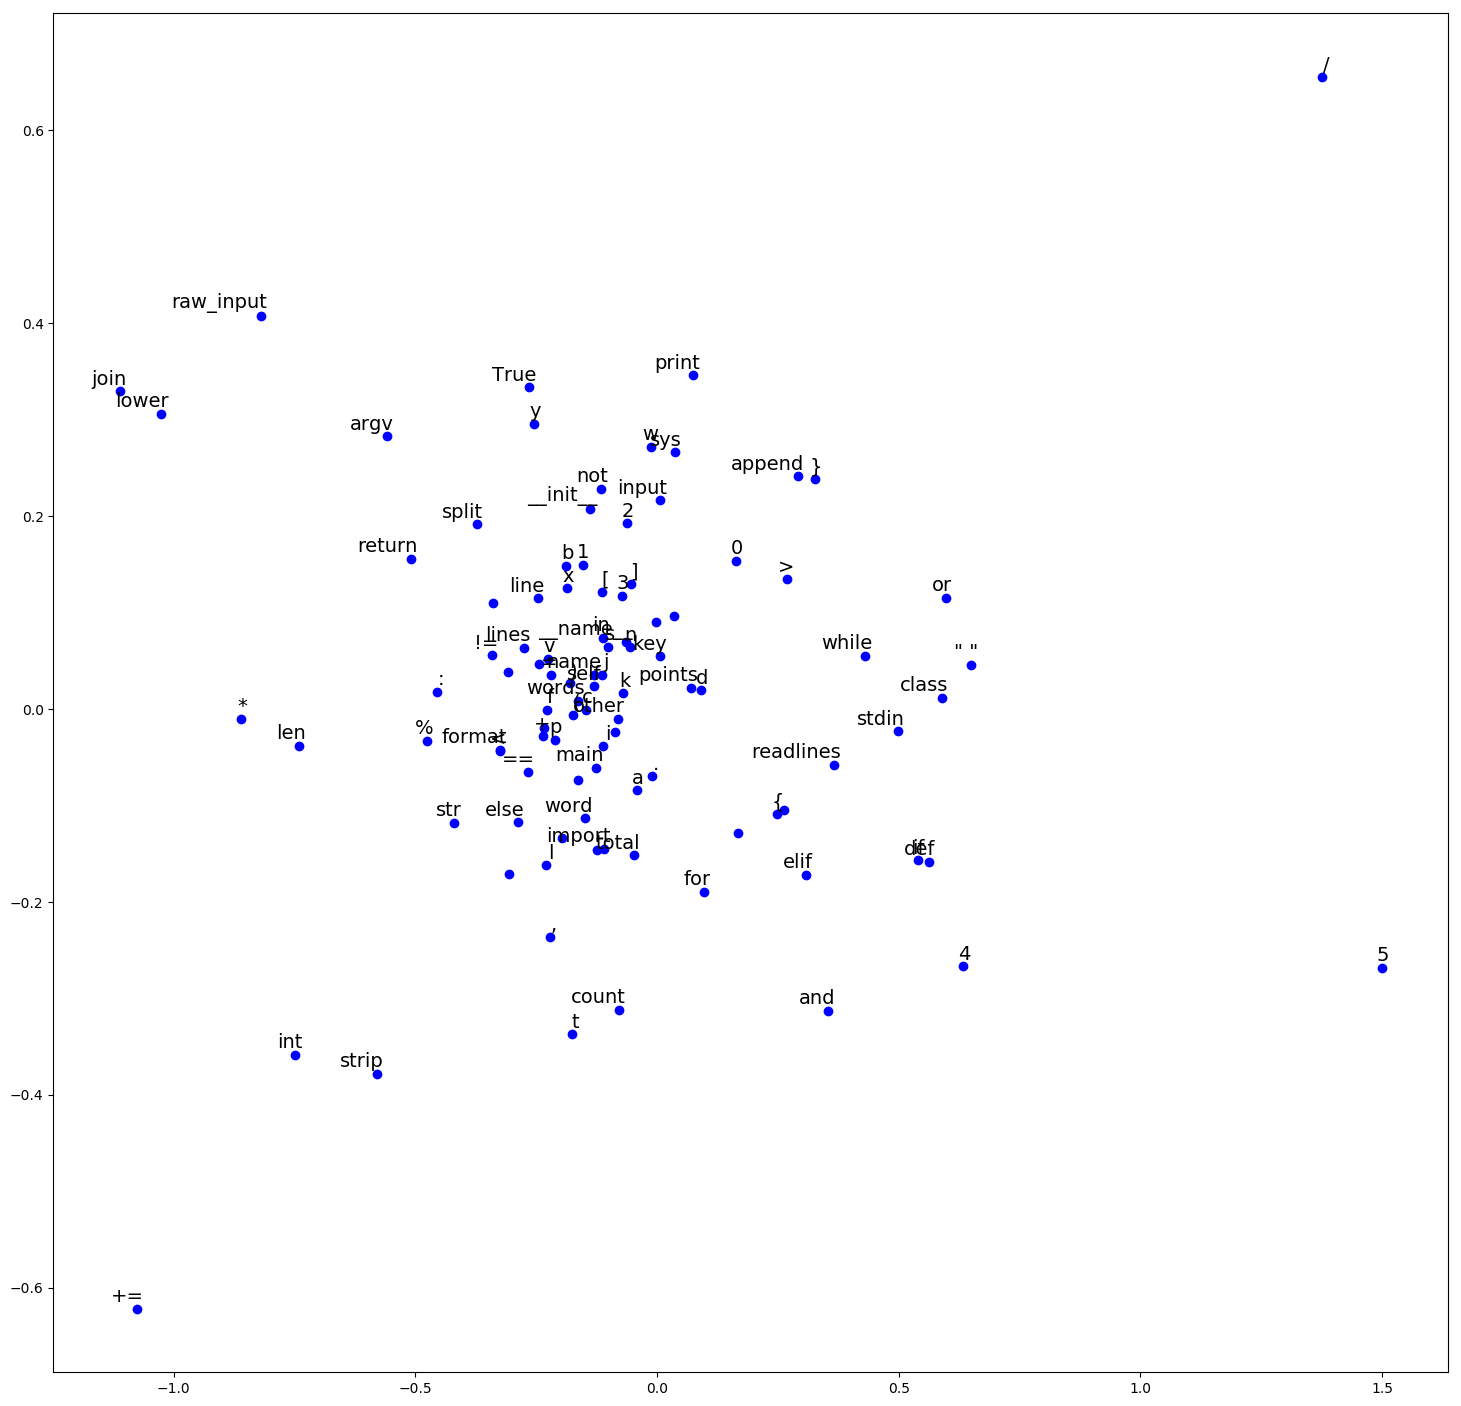

In [116]:
plot_dimensionality_reduction(pg_pca, id_to_word, top_words=top_words)